In [26]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import datetime
from implementations import *
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [ ]:
# Github does not accept files above 100mb and test.csv is 104mb
# thus we upload zip whith test.csv which needs to be extracted
with zipfile.ZipFile("../data/test.csv.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

In [6]:
#Let's modify the data: replace -999 by -9
x_99 = x
np.putmask(x_99, x_99==-999, -9)

ratio = 0.1
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_99, y, ratio)

#tx_train_99, tr_mean_99, tr_std_99 = standardize(x_train)
#tx_test_99, te_mean_99, te_std_99 = standardize(x_test)

tx_train_99 = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_99 = np.c_[np.ones((y_test.shape[0], 1)), x_test]

#Least squares
print("\t*** LS ****")
w_LS, rmse_tr = least_squares(y_train, tx_train_99)
rmse_te = compute_RMSE(y_test, tx_test_99, w_LS)
print(rmse_te)
print(rmse_tr)

#Gradient Descent
print("\t*** GS ****")
gamma = 0.00001
max_iters = 5
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_GD, rmse_tr_GD, = least_squares_GD(y_train, tx_train_99, initial_w, max_iters, gamma)
rmse_te_GD = compute_RMSE(y_test, tx_test_99, w_GD)
print(rmse_te_GD)
print(rmse_tr_GD)

#Newton
print("\t*** N ****")
gamma = 0.00002
max_iters = 5
lambd = 0.5
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_N, rmse_tr_N = learning_by_newton_method(y_train, tx_train_99, initial_w, max_iters, gamma)
rmse_te_N = compute_RMSE(y_test, tx_test_99, w_N)
print(rmse_te_N)
print(rmse_tr_N)

#Mean of 10 folds least squares
print("\t*** CLS ****")
k_folds = 10
seed = 2
w_LS_folds, rmse_tr_CLS, rmse_te_CLS = cross_validation_LS(y, x_99, k_folds, seed)

#Mean of weights along folds
w_CLS = w_LS_folds.mean(axis=0)
w_CLS = np.reshape(w_CLS, (tx_train_99.shape[1], 1))
test_mse_CLS_mean = compute_loss(y_test, tx_test_99, w_CLS)
train_mse_CLS_mean = compute_loss(y_train, tx_train_99, w_CLS)
rmse_te_CLS_mean = np.sqrt(2*test_mse_CLS_mean)
rmse_tr_CLS_mean = np.sqrt(2*train_mse_CLS_mean)
print("-mean weights:")
print(rmse_te_CLS_mean)
print(rmse_tr_CLS_mean)

#Best weights in test results
w_CLS_best = w_LS_folds[np.argmin(rmse_te_CLS)]
w_CLS_best = np.reshape(w_CLS_best, (tx_train_99.shape[1], 1))
test_mse_CLS_best = compute_loss(y_test, tx_test_99, w_CLS_best)
train_mse_CLS_best = compute_loss(y_train, tx_train_99, w_CLS_best)
rmse_te_CLS_best = np.sqrt(2*test_mse_CLS_best)
rmse_tr_CLS_best = np.sqrt(2*train_mse_CLS_best)
print("-best weights:")
print(rmse_te_CLS_best)
print(rmse_tr_CLS_best)

#Penalized Regression
lambd = 0.5
gamma = 0.00002
max_iters = 5
print("\t**** Penalized *******")
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_reg, rmse_tr_reg = reg_logistic_regression(y_train, tx_train_99, lambd, initial_w, max_iters, gamma)
rmse_te_reg = compute_RMSE(y_test, tx_test_99, w_reg)
print(rmse_te_reg)
print(rmse_tr_reg)

#kind of F1-measure
print("ratio of misclassified over total predictions: ")

y_pred_LS = predict_labels(w_CLS, tx_test_99)
f1_CLS = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("F1 CLS: {l}".format(l=f1_CLS))

y_pred_GS = predict_labels(w_GD, tx_test_99)
f1_GS = sum(abs(y_test-y_pred_GS))/(2*len(y_pred_GS))
print("F1 GS: {l}".format(l=f1_GS))

y_pred_N = predict_labels(w_N, tx_test_99)
f1_N = sum(abs(y_test-y_pred_N))/(2*len(y_pred_N))
print("F1 N: {l}".format(l=f1_N))

y_pred_PR = predict_labels(w_reg, tx_test_99)
f1_PR = sum(abs(y_test-y_pred_PR))/(2*len(y_pred_PR))
print("F1 PR: {l}".format(l=f1_PR))

	*** LS ****
0.824319370683
0.826956343995
	*** GS ****
0.928404908633
0.928677901986
	*** N ****
0.999809002735
0.999810306918
	*** CLS ****
-mean weights:
0.823861760302
0.82732031017
-best weights:
0.823867919796
0.827321865538
	**** Penalized *******
0.999808995056
0.999810331214
ratio of misclassified over total predictions: 
F1 CLS: [ 0.25511556]
F1 GS: [ 0.30983111]
F1 N: [ 0.31756444]
F1 PR: [ 0.31756]


In [ ]:
plt.plot(range(0,k_folds), rmse_tr_CLS)
plt.plot(range(0,k_folds), rmse_te_CLS, color='r')

In [ ]:
#plot variance and mean of test/train error of Least squares
plt.boxplot([rmse_te_CLS, rmse_tr_CLS])

In [66]:
x_nan = x.copy()
np.putmask(x_nan, x_nan==-999, np.nan)
x_square = np.zeros((x_nan.shape[0], 3*x_nan.shape[1]))


for column in range(0,x_nan.shape[1]):
    x_square[:, column] = x_nan[:, column]
    x_square[:, column+x_nan.shape[1]] = np.multiply(x_nan[:,column], x_nan[:,column])
    x_square[:, column+2*x_nan.shape[1]] = np.multiply(np.multiply(x_nan[:,column], x_nan[:,column]), x_nan[:,column])


x_square[np.isnan(x_square)]=-9

ratio = 0.4
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_square, y, ratio)

#tx_train_square, m, s = standardize(x_train)
#tx_test_square, m, s = standardize(x_test)

tx_train_square = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_square = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.ones((tx_train_square.shape[1], 1))

w_LS_pow3, rmse_LS_pow3 = least_squares(y_train, tx_train_square)
y_pred_LS = predict_labels(w_LS_pow3, tx_test_square)
f1_LS_pow3 = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("f1 score for LS: {f}".format(f=f1_LS_pow3))

lambds = np.logspace(-6, -5, 50)
best_f1 = 1000
best_lamb = 0
k_folds = 5
seed = 1
f1_mean = []
f1_std = []
for lamb in lambds:
    f1_rid, w_rid = cross_validation_ridge(y_train, tx_train_square, lamb, k_folds, seed)
    f1_rid = np.reshape(f1_rid, (len(f1_rid), 1))
    f1_mean.append(f1_rid.mean())
    f1_std.append(f1_rid.std())

#print("the best lmabda is {bl} with {f}".format(bl=best_lamb, f=best_f1))

f1 score for LS: [ 0.2193]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xscale'

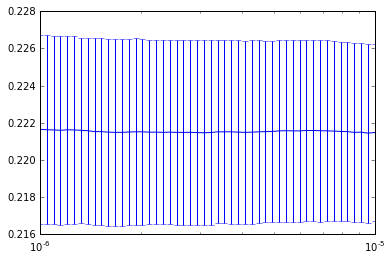

In [77]:
fig, ax = plt.subplots(nrows=1, sharex=True)
ax.errorbar(lambds, f1_mean, yerr = f1_std)
ax.set_xscale('log')
plt.show()

In [79]:
w_rid_mean = weights_ridge.mean(axis=0)
w_rid_best = weights_ridge[np.argmin(f1_ridge_folds)]

tx_total, m, s = standardize(x_square)

y_pred_mean = predict_labels(w_rid_mean, tx_total)
y_pred_mean = np.reshape(y_pred_mean, (len(y_pred_mean), 1))
f1_rid_mean = sum(abs(y-y_pred_mean))/(2*len(y_pred_mean))

print(1-f1_rid_mean)

y_pred_best = predict_labels(w_rid_best, tx_total)
y_pred_best = np.reshape(y_pred_best, (len(y_pred_best), 1))
f1_rid_best = sum(abs(y-y_pred_best))/(2*len(y_pred_best))

print(1-f1_rid_best)

[ 0.78004]
[ 0.780524]


In [ ]:
#IRLS
x_99 = x
np.putmask(x_99, x_99==-999, -99)
#PCA to avoid correlation and singular matrix
#eigenvectors, eigenvalues, V = np.linalg.svd(x_99.T, full_matrices=False)
#x_proj = np.dot(x_99, eigenvectors[:, 0:10])
#y = np.reshape(y, (len(y), 1))

ratio = 0.05
x_train_IRLS, x_test_IRLS, y_train_IRLS, y_test_IRLS = split_data(x_99, y, ratio)
tx_train_IRLS = np.c_[np.ones((y_train_IRLS.shape[0], 1)), x_train_IRLS]
tx_test_IRLS= np.c_[np.ones((y_test_IRLS.shape[0], 1)), x_test_IRLS]

max_iters = 5
print("\t*** IRLS *****")
initial_w  = np.ones((tx_train_IRLS.shape[1],1))
w_IRLS, rmse_tr_IRLS = learning_by_IRLS(y_train_IRLS, tx_train_IRLS, initial_w, max_iters)
rmse_te_IRLS = compute_RMSE(y_test_IRLS, tx_test_IRLS, w_IRLS)
print(rmse_te_IRLS)
print(rmse_tr_IRLS)

In [ ]:
#Not Sure what you wanted to achieve here
mean_w = w_LS.mean(axis=0)
std_w = w_LS.std(axis=0)
rmse_tr = compute_RMSE(y_train, tx_train_99, mean_w)
rmse_te = compute_RMSE(y_test, tx_test_99, mean_w)
print(rmse_tr)
print(rmse_te)

In [ ]:
x_s = standardize(x)
eigenvectors, eigenvalues, V = np.linalg.svd(x.T, full_matrices=False)
x_proj = np.dot(x, eigenvectors[:, 0:12])
print(eigenvectors.shape)
print(eigenvalues.shape)
print(V.shape)
print(x_proj.shape)
sigma = x_proj.std(axis=0).mean()
print(sigma)

# Do your thing crazy machine learning thing here :) ...

In [ ]:
#Something is missing

max_iter = 100
threshold = 1e-8
alpha = 0.001
ratio = 0.1
lambd = 0.01
losses = []

y = np.reshape(y, (len(y), 1))


x_train, x_test, y_train, y_test = split_data(x, y_vec, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
w = np.zeros((tx_train.shape[1], 1))

In [ ]:
ratio = 0.1
x_train, x_test, y_train, y_test = split_data(x, y, ratio)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
gamma = 0.001
x_train, x_test, y_train, y_test = split_data(x, y, ratio)
tx_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
initial_w  = np.zeros((tx_train.shape[1],1))

w, rmse = learning_by_newton_method(y_train, tx_train, initial_w, 100, gamma)
print(rmse)

In [ ]:
max_iter = 10
threshold = 1e-8
#alpha = 0.001
lambd = 0.1
ratio = 0.05
losses = []

gammas = np.logspace(-5, -1, 10)
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_99, y, ratio)

#tx_train, x_tr_mean, x_tr_std = standardize(x_train)
#tx_test, x_te_mean, x_te_std = standardize(x_test)

tx_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
for gamma in gammas:
    initial_w  = np.ones((tx_train.shape[1],1))
    w_NM, rmse_NM = learning_by_newton_method(y_train, tx_train, initial_w, max_iter, gamma)
#     lossREG = compute_loss(y_test, tx_test, w)
#     rmse = np.sqrt(2*lossREG)
    losses.append(rmse_NM)

In [ ]:
plt.semilogx(gammas[0:5], losses[0:5], marker=".", color='b')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.grid(True)

In [ ]:
# Was it working? in your version of learning_by_gradient_descent you had to provide max_iters to the function
# just as in my implemetnation

#Lets test some basics: Least Squares Gradient Descent
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 1000
threshold = 1e-8
alpha = 0.002
lambd = 0.001
ratio = 0.1
losses = []

# Initialization
#w_initial = weights

y = np.reshape(y, (len(y), 1))

x_train, x_test, y_train, y_test = split_data(x, y, ratio)

#tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
#tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]

tx_train, x_tr_mean, x_tr_std = standardize(x_train)
tx_test, x_te_mean, x_te_std = standardize(x_test)
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_gradient_descent(y_train, tx_train, w, alpha)
    if iter % 20 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
print("The loss={l}".format(l=compute_loss(y_test, tx_test, w)))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
k_fold = 20
seed = 1
lambd = 0.01
max_iters = 5
w_cv, lossTR_cv, lossTE_cv = cross_validation_laz(y, x_99, k_fold, seed, lambd, max_iters)

In [ ]:
# Was it working? in your version of learning_by_newton_method you had to provide max_iters to the function
# just as in my implemetnation

# Define the parameters of the algorithm.
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 100
threshold = 1e-8
alpha = 0.002
lambd = 0.001
ratio = 0.1
losses = []

# Initialization
#w_initial = weights

y_vec = np.zeros((y.shape[0], 1))
y_vec[:,0] = y

x_train, x_test, y_train, y_test = split_data(x, y_vec, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_newton_method(y_train, tx_train, w, alpha)
    if iter % 20 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
print("The loss={l}".format(l=compute_RMSE(y_test, tx_test, w)))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

# PCA

In [ ]:
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 10
threshold = 1e-8
alpha = 0.001
lambd = 0.001
ratio = 0.1
losses = []

eigenvectors, eigenvalues, V = np.linalg.svd(x.T, full_matrices=False)
x_proj = np.dot(x, eigenvectors[:, 0:10])
y = np.reshape(y, (len(y), 1))

x_train, x_test, y_train, y_test = split_data(x_proj, y, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_newton_method(y_train, tx_train, w, alpha)
    if iter % 10 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")

mse = compute_loss(y_test, tx_test, w)
rmse = np.sqrt(2*mse)
print("The loss={l}".format(l=rmse))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Newton: execution time={t:.3f} seconds".format(t=exection_time))



# ERROR

In [ ]:
mse = compute_loss(y_test, tx_test, w)
rmse = np.sqrt(2*mse)
print(rmse)

# K-fold

In [ ]:
max_iter = 20
threshold = 1e-8
alpha = 0.001
lambd = 0.001
ratio = 0.1
losses = []
k_fold = 20
seed = 1

#x_train, x_test, y_train, y_test = split_data(x, y, ratio)
#tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
#tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
#w = np.ones((x_train.shape[1]+1, 1))
y = np.reshape(y, (len(y), 1))

w_RegPen, tr_rmse, te_rmse = cross_validation_laz(y, x, k_fold, seed, lambd, max_iter)
print(w_LS.std(axis=0).mean())
print(tr_rmse)
print(te_rmse)

In [ ]:
weights_NM_20folds = w_LS
train_rmse_NM_20folds = tr_rmse
test_rmse_NM_20folds = te_rmse

## Generate predictions and save ouput in csv format for submission:

In [50]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

x_nan_test = X_test.copy()
np.putmask(x_nan_test, x_nan_test==-999, np.nan)
x_third = np.zeros((x_nan_test.shape[0], 3*x_nan_test.shape[1]))

for column in range(0,x_nan_test.shape[1]):
    x_third[:, column] = x_nan_test[:, column]
    x_third[:, column+x_nan_test.shape[1]] = np.multiply(x_nan_test[:,column], x_nan_test[:,column])
    x_third[:, column+2*x_nan_test.shape[1]] = np.multiply(np.multiply(x_nan_test[:,column], x_nan_test[:,column]), x_nan_test[:,column])

x_third[np.isnan(x_third)]=-9


In [53]:
weights = w_rid_best
tX_test, m, s = standardize(x_third)

In [54]:
OUTPUT_PATH = '../data/submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
# Delete train.csv such that github accepts push
os.remove('../data/test.csv')